# One vs All Regularized Logistic Regression

In [28]:
%pylab inline
from scipy.io import loadmat
import scipy.optimize as op
import doctest

Populating the interactive namespace from numpy and matplotlib


## Load Data

In [13]:
ex3data1 = loadmat('ex3data1.mat')
X, y = np.ascontiguousarray(ex3data1['X']), np.ascontiguousarray(ex3data1['y'])
# replace 10 class by 0
y[y[:,0] == 10, 0] = 0

## Plot Sample Data

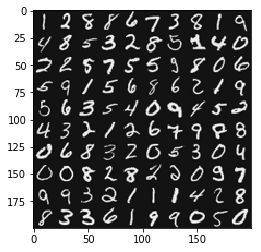

In [14]:
def plot_sample_data(X):
    X_copy = X.copy()
    np.random.shuffle(X_copy)
    img = np.reshape(X_copy[:100], (10,10,20,20)).transpose((0,3,1,2)).reshape((200,200))
    f = plt.imshow(img, cmap='gray');

plot_sample_data(X)

## Insert Bias Feature

In [15]:
def insert_bias_feature(X):
    """Insert a column filled with ones in front of an unbiased array of features.
    
    The new column is inserted at index ``0`` on axis ``1``.
    
    Parameters
    ----------
    X : array_like
        Input array.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``
        before the new column insertion.
        
    Returns
    -------
    numpy.ndarray
        Output array.
        If `X` has ``(m,n)`` shape, the return value will have ``(m,n+1)``shape.
        
    Examples
    --------
    >>> x = np.array([[2,3],[4,5],[6,7]])
    >>> insert_bias_feature(x)
    array([[1, 2, 3],
           [1, 4, 5],
           [1, 6, 7]])
     
    >>> x = np.array([[2],[3],[4]])
    >>> insert_bias_feature(x)
    array([[1, 2],
           [1, 3],
           [1, 4]])
     
    >>> x = [2,3,4]
    >>> insert_bias_feature(x)
    array([[1, 2],
           [1, 3],
           [1, 4]])
    """
    if np.ndim(X) == 1:
        X = np.reshape(X, (-1,1))
        
    return np.insert(X,0,1,axis=1)

## Initialize Theta

In [16]:
def initialize_theta(shape, order='C'):
    """Return a new array of given shape, filled with `numpy.float64` zeros.
    
    Parameters
    ----------
    shape : int or sequence of ints
        Shape of the new array, e.g., ``(2, 3)`` or ``2``.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory.
        
    Returns
    -------
    numpy.ndarray
        Array of `numpy.float64` zeros with the given shape and order.
    
    Examples
    --------
    >>> initialize_theta(5)
    array([0., 0., 0., 0., 0.])
    
    >>> initialize_theta((5,))
    array([0., 0., 0., 0., 0.])
    
    >>> initialize_theta((2, 1))
    array([[0.],
           [0.]])
    
    >>> initialize_theta((2,2))
    array([[0., 0.],
           [0., 0.]])
    """
    return np.zeros(shape)

## Sigmoid Function

In [17]:
def sigmoid(z):
    '''Compute the sigmoid function.
    
    Parameters
    ----------
    z : array_like
        Input data.
        
    Returns
    -------
    numpy.ndarray
        Element-wise ``sigmoid(z)``, of the same shape and dtype as `x`.
        Returns scalar if `x` is a scalar.
        
    Examples
    --------
    >>> sigmoid(0)
    0.5
    
    >>> sigmoid([-1,1])
    array([0.26894142, 0.73105858])

    >>> sigmoid(np.array([-1,1e2]))
    array([0.26894142, 1.        ])
    '''
    return 1 / (1 + np.exp(np.negative(z)))

## Regularized Cost Function

In [18]:
def regularized_logistic_loss(theta,X,y,lamb=0):
    """Compute regularized logistic regression cost from unbiased examples.

    Parameters
    ----------
    theta : array_like
        Parameters (weights) of the model, including the bias parameter.
        If `theta` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    X : array_like
        Input examples.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    y : array_like
        Output examples.
        If `y` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)```.
    lamb : float, optional
        Regularization parameter. Default value is ``0``.
        
    Returns
    -------
    numpy.float64
        Cost value.
    
    Examples
    --------
    >>> t = [[0.1],[0.2],[0.1]]
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [[0],[1],[0],[0],[1]]
    >>> l = 3
    >>> regularized_logistic_loss(t,x,y,l)
    8.87783302433269
    
    >>> t = [0.1,0.2,0.1]
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [0,1,0,0,1]
    >>> l = 3
    >>> regularized_logistic_loss(t,x,y,l)
    8.87783302433269
    """
    if np.ndim(theta) == 1:
        theta = np.reshape(theta,(-1,1))
    else:
        theta = np.array(theta)
    if np.ndim(y) == 1:
        y = np.reshape(y, (-1,1))
    else:
        y = np.array(y)
        
    X_biased = insert_bias_feature(X)
    z = X_biased @ theta
    a = sigmoid(z)
    J = (1/len(y)) * ((-y).T @ log(a) - (1-y).T @ log(1-a))
    reg = (lamb/(2*len(y))) * (theta[1:].T @ theta[1:])
    return np.sum(J + reg)

## Regularized Gradient Function

In [19]:
def regularized_logistic_gradient(theta,X,y,lamb=0):
    """Compute regularized logistic regression gradient from unbiased features.

    Parameters
    ----------
    theta : array_like
        Parameters (weights) of the model, including the bias parameter.
        If `theta` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    X : array_like
        Input examples.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    y : array_like
        Output examples.
        If `y` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)```.
    lamb : float, optional
        Regularization parameter. Default value is ``0``.
        
    Returns
    -------
    numpy.float64
        Cost gradient.
    
    Examples
    --------
    >>> t = [[0.1],[0.2],[0.1]]
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [[0],[1],[0],[0],[1]]
    >>> l = 3
    >>> regularized_logistic_gradient(t,x,y,l)
    array([ 0.59999762, 30.54369284, 27.24065013])
    
    >>> t = [0.1,0.2,0.1]
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [0,1,0,0,1]
    >>> l = 3
    >>> regularized_logistic_gradient(t,x,y,l)
    array([ 0.59999762, 30.54369284, 27.24065013])
    """
    if np.ndim(theta) == 1:
        theta = np.reshape(theta,(-1,1))
    else:
        theta = np.array(theta)
    if np.ndim(y) == 1:
        y = np.reshape(y, (-1,1))
        
    X_biased = insert_bias_feature(X)
    z = X_biased @ theta
    a = sigmoid(z)
    D = (1/len(y)) * X_biased.T @ (a-y)
    D[1:] += (lamb/len(y)) * theta[1:]
    return D.squeeze()

## Regularized Gradient Descent

In [20]:
def regularized_logistic_gradient_descent(X,y,lamb=0,method='tnc'):
    """Minimize logistic loss from unbiased examples using gradient descent method.
    
    Parameters
    ----------
    X : array_like
        Input examples.
        The input array must not include the bias column.
        If `X` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    y : array_like
        Output examples.
        If `y` is a 1-D array of shape ``(m,)``, it will be reshaped to ``(m,1)``.
    lamb : float, optional
        Regularization parameter. Default value is ``0``.
    method : str or callable, optional
        Type of solver.  Should be one of `scipy.optimize.minimize` solvers.
        Default to 'tnc'.
        
    Returns
    -------
    theta : numpy.ndarray
        The model's parameters (weights).
    
    Examples
    --------
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [[0],[1],[0],[0],[1]]
    >>> l = 3
    >>> regularized_logistic_gradient_descent(x,y,l)
    array([-24.28798976,   0.16039051,   0.22632985])
    
    >>> x = [[67.37202755, 42.83843832],
    ...      [89.67677575, 65.79936593],
    ...      [50.53478829, 48.85581153],
    ...      [34.21206098, 44.2095286 ],
    ...      [77.92409145, 68.97235999]]
    >>> y = [0,1,0,0,1]
    >>> l = 3
    >>> regularized_logistic_gradient_descent(x,y,l)
    array([-24.28798976,   0.16039051,   0.22632985])
    """
    m, n = np.shape(X)
    initial_theta = initialize_theta((n+1,1))
    result = op.minimize(fun=regularized_logistic_loss, x0=initial_theta, args=(X,y,lamb), method=method, jac=regularized_logistic_gradient)
    theta = result.x
    return theta

## One-vs-all Training

In [25]:
def train_classificator(X,y,lamb=0,method='cg'):
    _, n = X.shape
    classificator = initialize_theta((10,n+1))
    classes = range(10)
    for c in classes:
        y_binary = (y == c).astype(int)
        theta = regularized_logistic_gradient_descent(X,y_binary,lamb,method=method)
        classificator[c] = theta
    return classificator

## One-vs-all Prediction

In [26]:
def make_predictions(X,y,lamb=0,method='cg'):
    X_biased = insert_bias_feature(X)
    classificator = train_classificator(X,y,lamb,method)
    z = X_biased @ classificator.T
    a = sigmoid(z)
    predictions = a.argmax(axis=1)
    accuracy = np.mean(predictions == y[:,0])
    print(f'The classificator has an accuracy of {accuracy * 100}%')

make_predictions(X,y,lamb=0.1)

The classificator has an accuracy of 96.46000000000001%


## Unit Tests

In [29]:
doctest.testmod()

TestResults(failed=0, attempted=41)

In [32]:
# set the file name (required)
__file__ = 'ex3.ipynb'

# add ipython magics
import ipytest.magics
import pytest

In [34]:
%%run_pytest[clean] -qq -v

def test_insert_bias_feature():
    ipytest.assert_equals(insert_bias_feature([[2,3], [4,5], [6,7]]),
                          np.array([[1, 2, 3], [1, 4, 5], [1, 6, 7]]))
    ipytest.assert_equals(insert_bias_feature(np.array([[2],[3],[4]])),
                          np.array([[1, 2], [1, 3], [1, 4]]))
    ipytest.assert_equals(insert_bias_feature([2,3,4]),
                          np.array([[1, 2], [1, 3], [1, 4]]))

def test_initialize_theta():
    ipytest.assert_equals(initialize_theta(5), np.array([0., 0., 0., 0., 0.]))
    ipytest.assert_equals(initialize_theta((5,)), np.array([0., 0., 0., 0., 0.]))
    ipytest.assert_equals(initialize_theta((2, 1)), np.array([[0.], [0.]]))
    ipytest.assert_equals(initialize_theta((2,2)), np.array([[0., 0.], [0., 0.]]))
    
def test_sigmoid():
    ipytest.assert_equals(sigmoid(0), 0.5)
    ipytest.assert_equals(sigmoid([-1,1]), np.array([0.26894142, 0.73105858]))
    ipytest.assert_equals(sigmoid(np.array([-1,1e2])), np.array([0.26894142, 1.]))
    
def test_regularized_logistic_loss():
    ipytest.assert_equals(regularized_logistic_loss(
        theta=[[0.1],[0.2],[0.1]],
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[[0],[1],[0],[0],[1]],
        lamb=3), 8.87783302433269)
    ipytest.assert_equals(regularized_logistic_loss(
        theta=[0.1,0.2,0.1],
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[0,1,0,0,1],
        lamb=3), 8.87783302433269)

def test_regularized_logistic_gradient():
    ipytest.assert_equals(regularized_logistic_gradient(
        theta=[[0.1],[0.2],[0.1]],
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[[0],[1],[0],[0],[1]],
        lamb=3),
        np.array([0.59999762, 30.54369284, 27.24065013]))
    ipytest.assert_equals(regularized_logistic_gradient(
        theta=[0.1,0.2,0.1],
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[0,1,0,0,1],
        lamb=3),
        np.array([0.59999762, 30.54369284, 27.24065013]))
    
def test_regularized_logistic_gradient_descent():
    ipytest.assert_equals(regularized_logistic_gradient_descent(
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[[0],[1],[0],[0],[1]],
        lamb=3),
        np.array([-24.28798976,   0.16039051,   0.22632985]))
    ipytest.assert_equals(regularized_logistic_gradient_descent(
        X=[[67.37202755, 42.83843832],
           [89.67677575, 65.79936593],
           [50.53478829, 48.85581153],
           [34.21206098, 44.2095286 ],
           [77.92409145, 68.97235999]],
        y=[0,1,0,0,1],
        lamb=3),
        np.array([-24.28798976,   0.16039051,   0.22632985]))

......                                                                                                                                                                                               [100%]
6 passed in 0.11 seconds
